# Knowledge Distillation of a Neural Network
Demonstration of the Knowledge Distillation method on MNIST data
- Train an **"expensive"** and **large** model on MNIST data to achieve a good generalization performance. This is the **teacher** model.
- Create a much **cheaper and smaller** model but instead of using the actual labels, it uses the predictions of the teacher model on training data. These are the **soft labels** and this model is called **student**
- Compare its performance with the same model trained on actual labels. It turns out that the student model performs much better on generalizing on test data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

import utils

## MNIST data

In [4]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 归一化到0到1之间
X_train = X_train / 255.0
X_test = X_test / 255.0

# Add a channels dimension
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

In [9]:
X_train[0, :, :, 0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

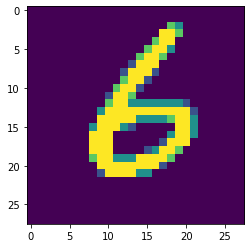

In [14]:
plt.imshow(X_train[66, :, :, 0])

In [15]:
# 训练集6w条，测试集1w条
num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_train, num_test

(60000, 10000)

In [16]:
tf.random.set_seed(0)

## Teacher VS Student
| |  Teacher   | Student  |
|  ----  |  ----  | ----  |
| net | conv  | dnn |
| layers | 3 | 2 |

## Teacher Model
Train a large and compute-intensive model that uses Dropout and generalizes well on test data.  
Here by "large" we mean a wide neural network with convolution filters and 2 fully-connected hidden layers.  

In [17]:
class TeacherModel(Model):
    def __init__(self, T: float):
        super(TeacherModel, self).__init__()
        
        self.T = T  # 温度系数T
        
        # 卷积层，filters: 32, kernel_size: 3
        # input_dim  = (batch_size, 28, 28, 1)
        # output_dim = (batch_size, 26, 26, 32)
        self.conv1 = Conv2D(32, 3, activation="relu") 
        self.flatten = Flatten() # 展平成(batch_size, 26*26*32)大小的矩阵
        
        self.d1 = Dense(1200, activation="relu")
        self.d2 = Dense(1200, activation="relu")
        self.d3 = Dense(10)     # 多分类有10个类别
        
        self.dropout_layer_hidden = tf.keras.layers.Dropout(rate=0.5)
        
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        
        x = self.d1(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d2(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d3(x)
        x = self.output_layer(x / self.T) # 使用温度T调整
        return x

In [18]:
T = 3.5  # Softmax temperature
teacher = TeacherModel(T=T)

### Train teacher model

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

teacher.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

2023-03-29 17:46:13.365097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-29 17:46:14.197567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P40 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 30 deviceMemorySize: 22.38GiB deviceMemoryBandwidth: 323.21GiB/s
2023-03-29 17:46:14.199426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P40 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 30 deviceMemorySize: 22.38GiB deviceMemoryBandwidth: 323.21GiB/s
2023-03-29 17:46:14.201216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:83:00.0 name: Tesla P40 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 30 deviceMemorySize: 22.38GiB deviceMemoryBandwidth: 323.21GiB/s
2023-03-29 17:46:14.203002: I t

In [20]:
num_epochs = 1
batch_size = 32

teacher.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.2)

2023-03-29 17:46:40.147018: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-29 17:46:40.381428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1500/1500 [==============================] - 12s 8ms/step - loss: 0.1934 - accuracy: 0.9382 - val_loss: 0.0767 - val_accuracy: 0.9755


### Evaluate generalization of teacher model

In [22]:
# teacher在验证集上的效果
y_pred_teacher = np.argmax(teacher(X_test), axis=1)

In [23]:
acc = accuracy_score(y_test, y_pred_teacher)
acc

0.9788

In [24]:
int((1 - acc) * num_test)

211

The teacher model achieved **211 test errors**

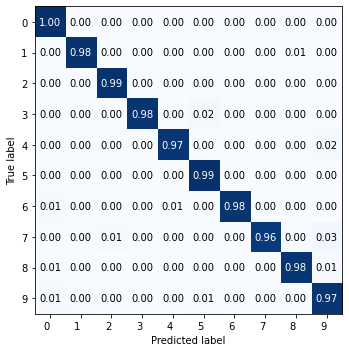

In [26]:
# 混淆矩阵
utils.plot_confusion_matrix(y_test, y_pred_teacher, classes=list(range(10)), normalize=True)
plt.show()

### Calculate teacher predictions on train set as well
These will be later used for training the student model

In [27]:
# teacher模型在训练集上的预估值，用于给student的知识蒸馏soft_label
y_train_pred_teacher = teacher(X_train)

2023-03-29 17:50:42.717966: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


## Student model
A much smaller and shallow neural network is used as the student model.

In [28]:
class StudentModel(Model):
    def __init__(self, T):
        super(StudentModel, self).__init__()
        
        self.T = T
        
        self.input_layer = tf.keras.layers.Flatten(input_shape=(28, 28)) # 直接将2D的图像数据展平，得到(batch_size, 28*28)维度的数据
        self.d1 = Dense(10, activation="relu")
        self.d2 = Dense(10)
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.input_layer(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.output_layer(x / self.T)
        return x

## Train small model on original labels

First we will train the small model on original labels and evaluate its performance on generalizing on test data.  
We expect that its performance will be worse than the teacher model since it has far less parameters

In [29]:
small_model = StudentModel(T=1.0)

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

small_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [31]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv) # 这里做了K折交叉验证
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    small_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = small_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(y_test_kf, y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

Fold: 1, accuracy: 0.7492
Fold: 2, accuracy: 0.75625
Fold: 3, accuracy: 0.84615


In [32]:
scores.mean()

0.7838666666666666

In [33]:
small_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_small = np.argmax(small_model.predict(X_test), axis=1)

In [34]:
acc = accuracy_score(y_test, y_pred_small)
acc

0.844

In [35]:
int((1 - acc)*num_test)

1560

The small model trained on original labels achieved **1560 test errors**

## Distill knowledge of the big teacher model to the small student model

In [36]:
student_model = StudentModel(T=3.5)

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

student_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [38]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    # 这里的label直接用了teacher的预估值，也就是soft_label来训练student模型
    y_train_kf, y_test_kf = y_train_pred_teacher.numpy()[train_index], y_train_pred_teacher.numpy()[test_index]

    student_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = student_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(np.argmax(y_test_kf, axis=1), y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

Fold: 1, accuracy: 0.91705
Fold: 2, accuracy: 0.9255
Fold: 3, accuracy: 0.9343


In [39]:
scores.mean()

0.9256166666666666

In [40]:
student_model.fit(X_train, y_train_pred_teacher, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_student = np.argmax(student_model(X_test), axis=1)

In [41]:
acc = accuracy_score(y_test, y_pred_student)
acc

0.9335

In [42]:
int((1 - acc)*num_test)

665

The distilled model trained on soft labels achieved **665 test errors**, **50% fewer errors than the same model trained on raw labels**